## Dependencies

In [271]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Stats Stuff
from scipy import stats
from scipy.stats import skew
import statsmodels.api as sm

# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)

# Turn off when showing off, switch comments to change
pd.options.mode.chained_assignment = None  # Disable the warning
# pd.options.mode.chained_assignment = 'warn'

## Importing and Prepping Schedules

In [272]:
schedules_df = nfl.import_schedules([2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [273]:
def calculate_implied_totals(df):
    """
    Calculate the implied home and away team totals based on the spread and total lines.
    """
    # Implied totals based on the total and spread lines
    df['implied_home_total'] = (df['total_line'] + df['spread_line']) / 2
    df['implied_away_total'] = (df['total_line'] - df['spread_line']) / 2
    
    return df

In [274]:
schedules_df = calculate_implied_totals(schedules_df)
# explore this if we can prove lines are out before upcoming week

In [275]:
schedules_df.drop(columns= ['away_coach', 'home_coach', 'referee',
       'stadium_id', 'stadium', 'away_score', 'home_score',
       'location', 'result', 'total', 'overtime', 'old_game_id', 'gsis',
       'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn', 'away_rest', 'home_rest',
       'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
       'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game', 'away_qb_id', 'home_qb_id', 'gameday', 'weekday',
       'gametime'], inplace=True)

In [276]:
# Create a DataFrame for away quarterbacks
away_df = schedules_df[['game_id', 'season', 'game_type', 'week', 'away_team', 'home_team', 'away_qb_name', 'implied_away_total', 'roof', 'surface',]].copy()
away_df.rename(columns={'away_qb_name': 'qb_name', 'implied_away_total': 'implied_total'}, inplace=True)
away_df['home_away'] = 'away'
away_df['posteam'] = away_df['away_team']
away_df['defteam'] = away_df['home_team']

# Create a DataFrame for home quarterbacks
home_df = schedules_df[['game_id', 'season', 'game_type', 'week', 'away_team', 'home_team', 'home_qb_name', 'implied_home_total', 'roof', 'surface']].copy()
home_df.rename(columns={'home_qb_name': 'qb_name', 'implied_home_total': 'implied_total'}, inplace=True)
home_df['home_away'] = 'home'
home_df['posteam'] = home_df['home_team']
home_df['defteam'] = home_df['away_team']

# Concatenate both DataFrames
combined_schedule_df = pd.concat([away_df, home_df])

# Reset index for cleanliness
combined_schedule_df.reset_index(drop=True, inplace=True)

In [277]:
def format_passer_name(qb_name):
    if pd.isna(qb_name):  # Check if the name is NaN
        return ""
    
    name_parts = qb_name.split()
    
    # Extract the first name and last name
    first_name = name_parts[0]
    last_name = name_parts[-1]  # Last name should always be the last part
    
    return f"{first_name[0]}.{last_name}"

# Apply the function to create the new 'player_passer_name' column
combined_schedule_df['passer_player_name'] = combined_schedule_df['qb_name'].apply(format_passer_name)

In [278]:
#Reorder Columns
combined_schedule_df = combined_schedule_df[['game_id', 'season', 'game_type', 'week', 'roof', 'surface',
                                             'posteam', 'defteam', 'home_team', 'away_team', 'qb_name', 'passer_player_name', 'implied_total', 'home_away']]

## Importing PBP Training Data

In [279]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2024 + 1), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


## Passer DF Prep

In [280]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Reorder the columns
passer_df = passer_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass' ,'game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

## Defense DF Prep

In [281]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Reorder the columns
defense_df = defense_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

## Preprocessing

In [282]:
def calculate_offensive_ewma(passer_df):
    """
    Calculates EWMA for offensive columns using previous weeks' data, ensuring no leakage by excluding the current week.
    Takes into account multiple seasons.
    """
    # Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    # Calculate the exponentially weighted moving average for each offensive feature, excluding the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    return passer_df

In [283]:
def pass_cleaner(passer_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    passer_df.drop(columns=['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe', 'home_team', 'away_team', 
                                    'complete_pass', 'incomplete_pass'], inplace=True)
    
    return passer_df

In [284]:
passer_emwa = calculate_offensive_ewma(passer_df)

In [285]:
passer_prepped = pass_cleaner(passer_emwa)

In [286]:
def calculate_defensive_ewma(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    # Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    # Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    return defense_df

In [287]:
def def_cleaner(defense_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    # Drop the non-ewma columns
    defense_df.drop(columns=['passing_yards','completion_percentage',
                            'air_yards', 'yards_after_catch', 'epa',     
                            'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe', 'complete_pass', 'incomplete_pass',
                            'home_team', 'away_team'
                            ], inplace=True)
    
    return defense_df

In [288]:
defense_ewma = calculate_defensive_ewma(defense_df)

In [289]:
defense_prepped = def_cleaner(defense_ewma)

In [290]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_prepped.merge(defense_prepped, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

# Get rid of flukey rows
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8) & (full_with_ewma['passing_yards'] >= 10)]

#Ford Field is empty, you hate to see that
filtered_with_ewma['surface'].replace('', 'fieldturf', inplace=True)

## Week 1 is NaN's (duh, we use past weeks for EWMA's) for MVP I'll just get rid but for future seasons/rookies I do need a strategy

In [291]:
filtered_with_ewma = filtered_with_ewma.dropna()

In [292]:
# Perform the merge based on game_id, season, week, and team
filtered_with_ewma_it = pd.merge(filtered_with_ewma, combined_schedule_df[['game_id', 'season', 'week', 'posteam', 'implied_total']], 
                     on=['game_id', 'season', 'week', 'posteam'], 
                     how='inner')

## Modeling

In [368]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma_it.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id', 'implied_total'])

# Define categorical and numeric columns
categorical_columns = ['roof', 'surface', 'home_flag_passer', 'home_flag_defense']
numeric_columns = [col for col in features if col not in categorical_columns]

# Split the data into training (up to 2023) and testing (2024)
train_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] <= 2023]
test_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] == 2024]

# Separate features and target for both training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# # Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Apply the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [388]:
# Initialize the basic XGBoost model
xgb_model_basic = xgb.XGBRegressor(
    n_estimators=142,  # Basic number of boosting rounds
    learning_rate=0.101,  # Standard learning rate
    max_depth=3,        # Typical depth for a basic model
    reg_lambda= 2,
    random_state=42,    # For reproducibility
    n_jobs=-1           # Use all CPU cores for faster training
)

# Train the model on the entire pre-2024 data
xgb_model_basic.fit(X_train_transformed, y_train)

# Make predictions on the 2024 season (X_test)
y_pred = xgb_model_basic.predict(X_test_transformed)

# Calculate RMSE for the 2024 season predictions
rmse_basic = mean_squared_error(y_test, y_pred, squared=False)
print(f"Basic RMSE on the 2024 season: {rmse_basic}")

# Attach predictions back to the original test DataFrame
test_data['predicted_passing_yards'] = y_pred

# # Display the updated DataFrame
# test_data[['passer_player_name', 'posteam', 'week', 'passing_yards', 'predicted_passing_yards']]

# Remove the rows with the largest and smallest passing yards
max_passing_yards = test_data['passing_yards'].max()
min_passing_yards = test_data['passing_yards'].min()

# Filter the test_data to exclude the rows with max and min passing yards
filtered_test_data = test_data[(test_data['passing_yards'] != max_passing_yards) & (test_data['passing_yards'] != min_passing_yards)]

# Calculate RMSE for the remaining data
rmse_filtered = mean_squared_error(filtered_test_data['passing_yards'], filtered_test_data['predicted_passing_yards'], squared=False)
print(f"RMSE on the 2024 season without the min and max true passing yard games: {rmse_filtered}")

Basic RMSE on the 2024 season: 71.89083862304688
RMSE on the 2024 season without the min and max true passing yard games: 68.68502807617188


In [389]:
# Ensure test_data contains the 2024 season
test_data = filtered_with_ewma_it[filtered_with_ewma_it['season'] == 2024]

In [390]:
# Attach predictions back to the original test DataFrame
test_data['predicted_passing_yards'] = y_pred

In [391]:
# Calculate whether the model over-predicted or under-predicted
test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']

## Current Week Preprocessing

In [395]:
def calculate_ewma_tester_off(passer_df):
    """
    Calculates EWMA for offensive columns using the current and previous weeks' data, including the current week.
    Takes into account multiple seasons.
    """
    # Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    # Calculate the exponentially weighted moving average for each offensive feature, including the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    return passer_df

In [396]:
passer_df_tester = passer_df[(passer_df['season'] == 2024)]

In [397]:
prediction_set_passer_nc = calculate_ewma_tester_off(passer_df_tester)

In [398]:
prediction_set_passer = pass_cleaner(prediction_set_passer_nc)

In [399]:
# Get rid of flukey rows and get current week offensive stuff ready to join on a prepped schedules DF
prediction_set_passer_recents = prediction_set_passer[(prediction_set_passer['pass_attempts'] > 8) & (prediction_set_passer['passing_yards'] >= 10)]

# prediction_set_passer_recents = prediction_set_passer_recents.loc[prediction_set_passer_recents.groupby('posteam')['week'].idxmax()]

# Filter rows where the 'week' is 7 for each 'posteam'
prediction_set_passer_recents = prediction_set_passer_recents[prediction_set_passer_recents['week'] == 6]


prediction_set_passer_recents['surface'].replace('', 'fieldturf', inplace=True)

prediction_set_passer_recents.drop(columns=['game_id', 'passer_player_name', 'defteam', 'roof', 'surface', 'home_flag', 'passing_yards', 'pass_attempts'], inplace=True)

In [400]:
def calculate_ewma_tester_def(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    # Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    # Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    return defense_df

In [401]:
defense_df_tester = defense_df[defense_df['season'] == 2024]

In [402]:
prediction_set_defense_nc = calculate_ewma_tester_def(defense_df_tester)

In [403]:
prediction_set_defense = def_cleaner(prediction_set_defense_nc)

In [404]:
# prediction_set_defense_recents = prediction_set_defense.loc[prediction_set_defense.groupby('defteam')['week'].idxmax()]

prediction_set_defense_recents = prediction_set_defense[prediction_set_defense['week'] == 6]


prediction_set_defense_recents['surface'].replace('', 'fieldturf', inplace=True)

prediction_set_defense_recents.drop(columns=['roof', 'surface', 'home_flag'], inplace=True)

In [405]:
def update_week_to_next(df):
    """
    Function to update all teams to the next NFL week based on the current max week.
    Teams that are behind the max week will jump to the next NFL week.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing NFL data including the 'week' column.
    
    Returns:
    pd.DataFrame: DataFrame with 'week' values updated appropriately.
    """
    # Copy the dataframe to avoid altering the original
    df_copy = df.copy()

    # Find the maximum value of 'week' in the dataframe (the current NFL week)
    current_week = df_copy['week'].max()

    # Increment all weeks to the next NFL week (based on current max week)
    df_copy['week'] = df_copy['week'].apply(lambda x: current_week + 1)
    
    return df_copy

In [406]:
current_week_offense_set = update_week_to_next(prediction_set_passer_recents)
current_week_defense_set = update_week_to_next(prediction_set_defense_recents)

In [407]:
current_week_defense_set.rename(columns={
    'completion_percentage_ewma': 'completion_percentage_ewma_defense',
    'pass_attempts_ewma': 'pass_attempts_ewma_defense',
    'air_yards_ewma': 'air_yards_ewma_defense',
    'yards_after_catch_ewma': 'yards_after_catch_ewma_defense',
    'epa_ewma': 'epa_ewma_defense',
    'interception_ewma': 'interception_ewma_defense',
    'qb_hit_ewma': 'qb_hit_ewma_defense',
    'sack_ewma': 'sack_ewma_defense',
    'pass_touchdown_ewma': 'pass_touchdown_ewma_defense',
    'passing_yards_ewma': 'passing_yards_ewma_defense',
    'cpoe_ewma': 'cpoe_ewma_defense'
}, inplace=True)

In [408]:
current_week_offense_set.rename(columns={
    'completion_percentage_ewma': 'completion_percentage_ewma_passer',
    'pass_attempts_ewma': 'pass_attempts_ewma_passer',
    'air_yards_ewma': 'air_yards_ewma_passer',
    'yards_after_catch_ewma': 'yards_after_catch_ewma_passer',
    'epa_ewma': 'epa_ewma_passer',
    'interception_ewma': 'interception_ewma_passer',
    'qb_hit_ewma': 'qb_hit_ewma_passer',
    'sack_ewma': 'sack_ewma_passer',
    'pass_touchdown_ewma': 'pass_touchdown_ewma_passer',
    'passing_yards_ewma': 'passing_yards_ewma_passer',
    'cpoe_ewma': 'cpoe_ewma_passer'
}, inplace=True)

In [409]:
combined_schedule_preds = combined_schedule_df[combined_schedule_df['season'] == combined_schedule_df['season'].max()]
combined_schedule_preds.drop(columns=['home_away'], inplace=True)

In [410]:
# Merge the two DataFrames on relevant columns, avoiding duplicates
off_plus_schedule = pd.merge(
    current_week_offense_set, 
    combined_schedule_preds, 
    on=['season', 'week', 'posteam'], 
    suffixes=('_fromoff', '_fromschedule'), 
    how='inner'
)

In [411]:
# Perform the merge on season, week, and defteam
full_pred_features = pd.merge(
    off_plus_schedule,
    current_week_defense_set,
    on=['season', 'week', 'defteam'],  # Merging on these columns
    suffixes=('_fromscheduleAHHHHHH', '_DEFENSEHUGSYDEFENSEHUGSY'), #this should make it obvious if there's an error
    how='inner'
)


In [412]:
# List of the new column order
new_column_order = ['game_id', 'season', 'week','game_type','posteam', 'defteam', 'home_team', 'away_team', 'qb_name', 'passer_player_name', 
              'implied_total', 'roof', 'surface',
              'completion_percentage_ewma_passer', 'pass_attempts_ewma_passer',
              'air_yards_ewma_passer', 'yards_after_catch_ewma_passer',
              'epa_ewma_passer', 'interception_ewma_passer', 'qb_hit_ewma_passer',
              'sack_ewma_passer', 'pass_touchdown_ewma_passer',
              'passing_yards_ewma_passer', 'cpoe_ewma_passer', 'completion_percentage_ewma_defense',
              'pass_attempts_ewma_defense', 'air_yards_ewma_defense',
              'yards_after_catch_ewma_defense', 'epa_ewma_defense',
              'interception_ewma_defense', 'qb_hit_ewma_defense', 'sack_ewma_defense',
              'pass_touchdown_ewma_defense', 'passing_yards_ewma_defense',
              'cpoe_ewma_defense']

# Reorder inplace
full_pred_features = full_pred_features[new_column_order]

# Create the home_flag_passer column
full_pred_features['home_flag_passer'] = full_pred_features['posteam'] == full_pred_features['home_team']

# Create the home_flag_defense column
full_pred_features['home_flag_defense'] = full_pred_features['defteam'] == full_pred_features['home_team']

In [420]:
def predict_passing_yards(df, model, preprocessor, features, categorical_columns, numeric_columns, target_column='predicted_passing_yards'):
    """
    Function to make passing yard predictions on a new dataframe.
    
    Parameters:
    new_data (pd.DataFrame): The new dataframe containing feature columns.
    model (xgb.XGBRegressor): Trained XGBoost model.
    preprocessor (ColumnTransformer): Preprocessor object for transforming the features.
    features (list): List of feature columns used by the model.
    categorical_columns (list): List of categorical columns to be preprocessed.
    numeric_columns (list): List of numeric columns to be preprocessed.
    target_column (str): The name of the column for storing the predictions. Default is 'predicted_passing_yards'.
    
    Returns:
    pd.DataFrame: The input dataframe with an added column of predicted passing yards.
    """
    
    # Select and transform the features from the new data
    X_new = df[features]
    
    # Apply preprocessing (scaling and encoding)
    X_new_transformed = preprocessor.transform(X_new)
    
    # Make predictions using the trained model
    df[target_column] = model.predict(X_new_transformed)
    
    return df

# Example usage
upcoming_week_predictions = predict_passing_yards(full_pred_features, xgb_model_basic, preprocessor, features, categorical_columns, numeric_columns)

In [422]:
upcoming_week_predictions

,game_id,season,week,game_type,posteam,defteam,home_team,away_team,qb_name,passer_player_name,implied_total,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense,home_flag_passer,home_flag_defense,predicted_passing_yards
0,2024_07_CAR_WAS,2024,7,REG,CAR,WAS,WAS,CAR,Andy Dalton,A.Dalton,21.00,outdoors,grass,0.697333,33.950413,247.983471,73.611570,-6.971384,1.636364,3.818182,0.719008,1.561983,202.561983,0.772449,0.736562,26.027473,247.934066,128.467033,4.231734,0.667582,5.409341,3.250000,1.065934,267.810440,9.057069,False,True,244.598068
1,2024_07_NYJ_PIT,2024,7,REG,NYJ,PIT,PIT,NYJ,Aaron Rodgers,A.Rodgers,20.50,outdoors,grass,0.646326,38.329670,292.917582,131.423077,3.203119,1.337912,6.881868,3.109890,1.848901,276.112637,-2.402754,0.694697,37.991758,257.239011,144.241758,0.568928,1.134615,4.032967,1.406593,1.288462,253.736264,-0.285749,False,True,252.774231
2,2024_07_BAL_TB,2024,7,REG,TB,BAL,TB,BAL,Baker Mayfield,B.Mayfield,23.00,outdoors,grass,0.736037,31.879121,199.489011,206.895604,4.382581,2.035714,1.980769,1.255495,3.530220,289.107143,-3.464517,0.696420,35.760989,295.285714,114.697802,11.017868,0.233516,7.532967,3.013736,2.508242,292.755495,8.694164,True,False,274.752136
3,2024_07_DEN_NO,2024,7,REG,DEN,NO,NO,DEN,Bo Nix,B.Nix,19.75,dome,sportturf,0.618549,30.274725,280.648352,82.291209,-3.002770,0.689560,4.505495,2.024725,1.854396,202.236264,-4.485404,0.721825,34.324176,218.082418,231.837912,2.456544,2.346154,3.170330,1.321429,2.678571,318.870879,-2.560734,False,True,218.942459
4,2024_07_HOU_GB,2024,7,REG,HOU,GB,GB,HOU,C.J. Stroud,C.Stroud,22.75,outdoors,grass,0.688510,32.304945,263.109890,97.906593,4.014143,0.939560,4.656593,1.840659,2.412088,235.524725,4.091304,0.687106,34.280220,241.065934,104.403846,-2.983443,0.376374,3.178571,1.027473,1.175824,229.991758,-0.987258,False,True,247.506134
5,2024_07_PHI_NYG,2024,7,REG,NYG,PHI,NYG,PHI,Daniel Jones,D.Jones,19.75,outdoors,fieldturf,0.615858,37.008242,262.483516,125.239011,-6.869754,0.747253,5.629121,2.148352,0.510989,222.700549,-3.587314,0.672734,28.669421,175.330579,135.892562,3.390191,0.082645,6.190083,3.909091,0.586777,208.578512,-2.213266,True,False,225.640732
6,2024_07_NE_JAX,2024,7,REG,NE,JAX,JAX,NE,Drake Maye,D.Maye,18.00,outdoors,grass,0.608871,25.250000,178.750000,101.750000,-12.627508,1.500000,6.750000,3.500000,2.250000,187.750000,-8.195461,0.792755,32.821429,177.618132,151.821429,13.999963,0.667582,4.329670,3.065934,3.587912,270.730769,12.932795,False,True,164.857468
7,2024_07_CIN_CLE,2024,7,REG,CLE,CIN,CLE,CIN,Deshaun Watson,D.Watson,18.00,outdoors,grass,0.661942,25.197802,166.307692,111.032967,-3.391251,0.079670,8.766484,5.348901,0.348901,159.868132,-2.221175,0.601352,38.505495,300.332418,133.293956,-3.942960,0.758242,5.837912,1.626374,1.104396,238.469780,-5.211413,True,False,218.207657
8,2024_07_SEA_ATL,2024,7,REG,SEA,ATL,ATL,SEA,Geno Smith,G.Smith,24.50,closed,fieldturf,0.644217,46.903846,376.480769,167.269231,0.860578,1.461538,5.945055,2.552198,1.000000,311.093407,0.469421,0.743136,33.211538,221.115385,86.711538,-1.123934,1.442308,2.673077,0.310440,2.060440,212.620879,3.482650,False,True,242.440414
9,2024_07_TEN_BUF,2024,7,REG,BUF,TEN,BUF,TEN,Josh Allen,J.Allen,25.00,outdoors,a_turf,0.641791,26.478022,247.519231,89.173077,6.209240,0.000000,3.964286,1.785714,1.670330,194.318681,7.078369,0.609790,32.074380,283.421488,92.776860,-1.368977,0.669421,2.785124,0.735537,1.462810,168.099174,-3.954318,True,False,233.914459


In [430]:
clean_predictions = upcoming_week_predictions[['game_id', 'season', 'week', 'game_type', 'posteam', 'defteam',
       'home_team', 'away_team', 'qb_name', 'predicted_passing_yards',
       'implied_total']]

clean_predictions

,game_id,season,week,game_type,posteam,defteam,home_team,away_team,qb_name,predicted_passing_yards,implied_total
0,2024_07_CAR_WAS,2024,7,REG,CAR,WAS,WAS,CAR,Andy Dalton,244.598068,21.00
1,2024_07_NYJ_PIT,2024,7,REG,NYJ,PIT,PIT,NYJ,Aaron Rodgers,252.774231,20.50
2,2024_07_BAL_TB,2024,7,REG,TB,BAL,TB,BAL,Baker Mayfield,274.752136,23.00
3,2024_07_DEN_NO,2024,7,REG,DEN,NO,NO,DEN,Bo Nix,218.942459,19.75
4,2024_07_HOU_GB,2024,7,REG,HOU,GB,GB,HOU,C.J. Stroud,247.506134,22.75
5,2024_07_PHI_NYG,2024,7,REG,NYG,PHI,NYG,PHI,Daniel Jones,225.640732,19.75
6,2024_07_NE_JAX,2024,7,REG,NE,JAX,JAX,NE,Drake Maye,164.857468,18.00
7,2024_07_CIN_CLE,2024,7,REG,CLE,CIN,CLE,CIN,Deshaun Watson,218.207657,18.00
8,2024_07_SEA_ATL,2024,7,REG,SEA,ATL,ATL,SEA,Geno Smith,242.440414,24.50
9,2024_07_TEN_BUF,2024,7,REG,BUF,TEN,BUF,TEN,Josh Allen,233.914459,25.00


## Charts for model stuff if I need to look. It's a pretty shit model. It does ok I guess but not a lot of variance in projection lmao

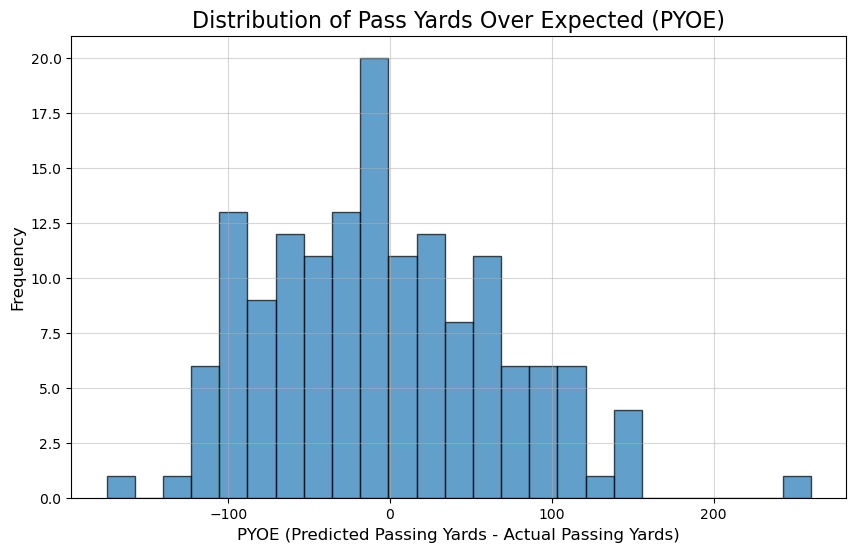

In [414]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['pyoe'], bins=25, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards Over Expected (PYOE)', fontsize=16)
plt.xlabel('PYOE (Predicted Passing Yards - Actual Passing Yards)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

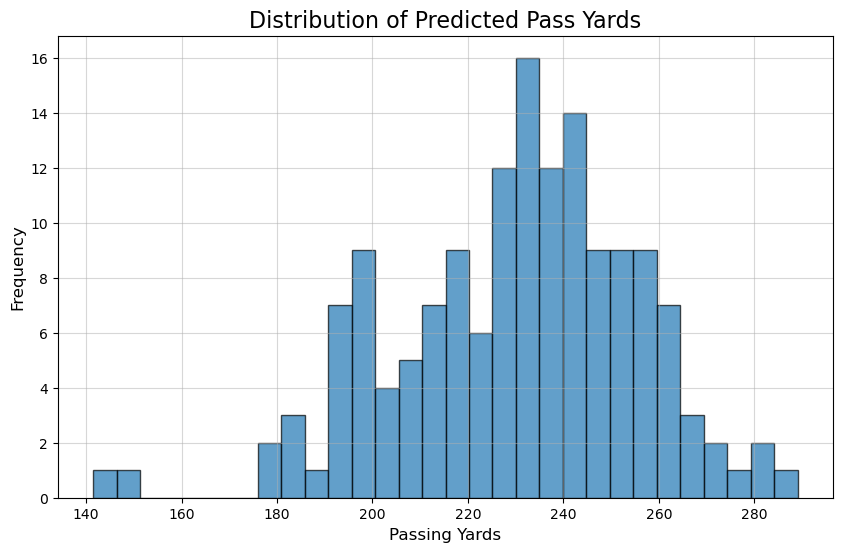

In [415]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['predicted_passing_yards'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predicted Pass Yards', fontsize=16)
plt.xlabel('Passing Yards', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

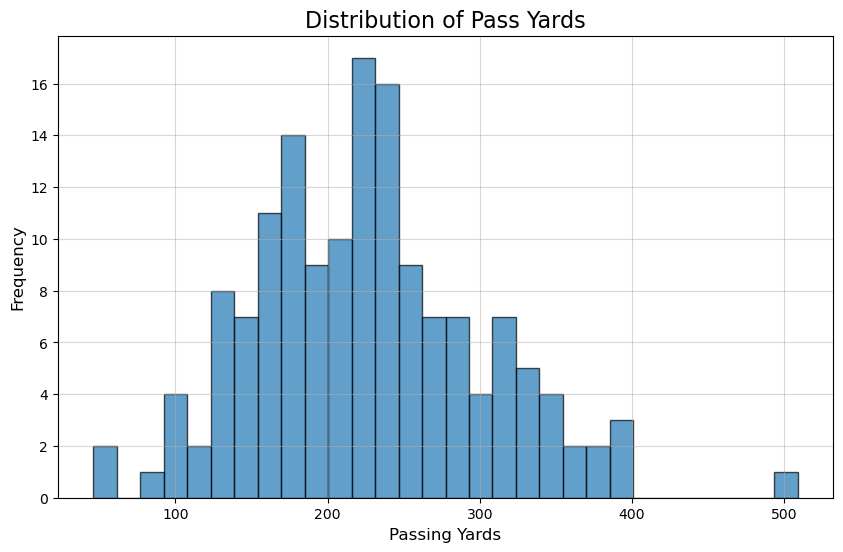

In [416]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['passing_yards'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards', fontsize=16)
plt.xlabel('Passing Yards', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

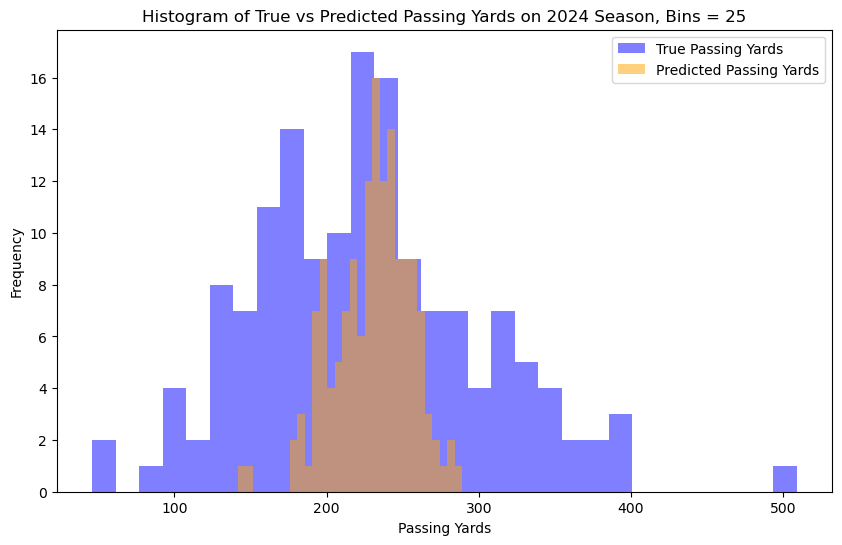

In [417]:
# Plotting the histogram of predicted passing yards and true passing yards
plt.figure(figsize=(10, 6))

# Plot histogram for true passing yards
plt.hist(test_data['passing_yards'], bins=30, alpha=0.5, label='True Passing Yards', color='blue')

# Plot histogram for predicted passing yards
plt.hist(test_data['predicted_passing_yards'], bins=30, alpha=0.5, label='Predicted Passing Yards', color='orange')

# Adding labels and title
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of True vs Predicted Passing Yards on 2024 Season, Bins = 25')
plt.legend(loc='upper right')

# Show the plot
plt.show()